# Data Analysis Module
## CAES Dataset Notebook

This module is in charge of data analysis for the project, including the raw dataset and scored counterfactuals.

### Dataset analysis:

In [162]:
import pandas as pd

# load df
df = pd.read_csv("caes/cleaned_caes.csv")
print("Shape:", df.shape)
df

Shape: (26653, 5)


,essay_id,full_text,score,word_count,prompt_name
0,0,hola carlos ! hace mucho que no te veo hombre ...,B1,212,Carta amigo
1,1,"hola querida sara , espero que estes muy bien ...",A2,175,Carta amigo
2,2,como estais ? ! hola amigos ! ? espero que tod...,A1,104,Postal vacaciones
3,3,"cuando llegué a el destino , le propuso que si...",A2,135,Postal vacaciones
4,4,¿ que tal ? un beso espero que todo va bien po...,A1,80,Familia
...,...,...,...,...,...
26648,26648,buenas tardes ! 29_de_mayo_de_2019 salamanca q...,B1,299,Carta amigo
26649,26649,tengo la seguridad de mí mismo para contener e...,B2,157,Solicitud admisión
26650,26650,"distinguidos señor / señra : hola , gerente . ...",B1,178,Reclamación compañía aérea
26651,26651,le escribo esta carta porque me gustaría inmen...,B2,303,Solicitud admisión


In [163]:
print("Column names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Column names: ['essay_id', 'full_text', 'score', 'word_count', 'prompt_name']

Data types:
 essay_id        int64
full_text      object
score          object
word_count      int64
prompt_name    object
dtype: object

Missing values:
 essay_id       0
full_text      0
score          0
word_count     0
prompt_name    0
dtype: int64


In [164]:
df[["word_count"]].describe()

,word_count
count,26653.000000
mean,185.708025
std,84.704274
min,80.000000
25%,123.000000
50%,164.000000
75%,227.000000
max,771.000000


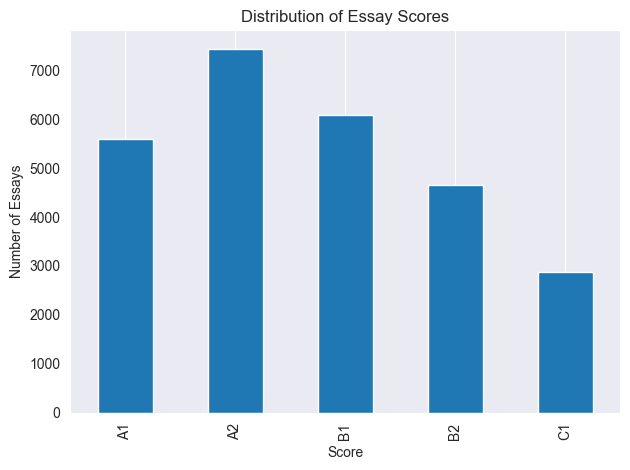

In [165]:
import matplotlib.pyplot as plt

df["score"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Number of Essays")
plt.grid(axis="y")
plt.tight_layout()

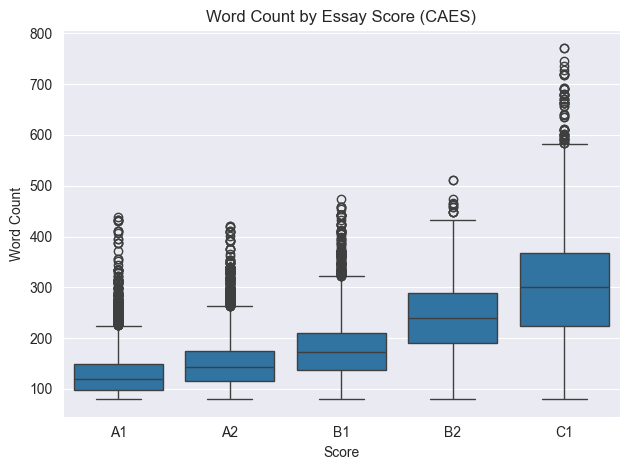

In [166]:
import seaborn as sns

# define order
order = ["A1","A2","B1","B2","C1"]
df["score"] = pd.Categorical(df["score"], categories=order, ordered=True)

# plot
sns.boxplot(data=df, x="score", y="word_count")
plt.title("Word Count by Essay Score (CAES)")
plt.xlabel("Score")
plt.ylabel("Word Count")
plt.tight_layout()

In [167]:
df.groupby("score")["word_count"].agg(['count','mean','median','std'])

/var/folders/4n/slwln6451ql9kp_wwdcstgf00000gn/T/ipykernel_63612/3238444863.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("score")["word_count"].agg(['count','mean','median','std'])


,count,mean,median,std
score,,,,
A1,5599,130.937846,119.0,45.547215
A2,7440,151.941801,143.0,50.012279
B1,6079,178.462905,173.0,57.701849
B2,4658,240.350580,239.0,69.142278
C1,2877,306.457769,301.0,113.500011


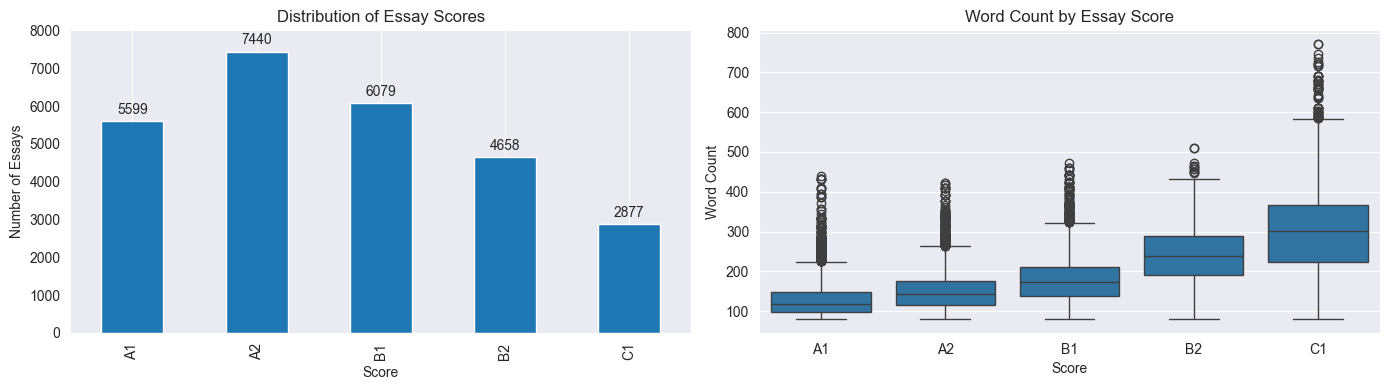

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# define the order and make score an ordered cat
order = ['A1', 'A2', 'B1', 'B2', 'C1']
df['score'] = pd.Categorical(df['score'], categories=order, ordered=True)

# create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax0 = axes[0]
bars = df['score'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', ax=ax0)

ax0.set_title("Distribution of Essay Scores")
ax0.set_xlabel("Score")
ax0.set_ylabel("Number of Essays")
ax0.grid(axis="y")
ax0.set_ylim(0, 8000)

# annotate each bar with its count
for bar in ax0.patches:
    height = bar.get_height()
    ax0.annotate(
        f'{int(height)}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom'
    )

sns.boxplot(
    data=df,
    x='score',
    y='word_count',
    ax=axes[1]
)
axes[1].set_title("Word Count by Essay Score")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Word Count")

plt.tight_layout()
fig.savefig(
    "plots/caes_combined.pdf",
    format="pdf",
    bbox_inches="tight"
)

### Tagged Dataset Analysis

In [133]:
stance_labels = {0: "PRO", 1: "CON", 2: "NEUTRAL"}
sentiment_labels = {0: "POSITIVE", 1: "NEGATIVE", 2: "NEUTRAL"}
formality_labels = {0: "FORMAL", 1: "INFORMAL", 2: "NEUTRAL"}

# load tagged dataset
df_tagged = pd.read_csv("caes/tagged_caes.csv")
print("Tagged shape:", df_tagged.shape)
df_tagged.head()

Tagged shape: (26653, 8)


,essay_id,full_text,score,word_count,prompt_name,stance,formality,sentiment
0,0,hola carlos ! hace mucho que no te veo hombre ...,B1,212,Carta amigo,0.0,1.0,1
1,1,"hola querida sara , espero que estes muy bien ...",A2,175,Carta amigo,0.0,1.0,0
2,2,como estais ? ! hola amigos ! ? espero que tod...,A1,104,Postal vacaciones,2.0,1.0,0
3,3,"cuando llegué a el destino , le propuso que si...",A2,135,Postal vacaciones,0.0,1.0,0
4,4,¿ que tal ? un beso espero que todo va bien po...,A1,80,Familia,0.0,1.0,0


In [134]:
# count nulls (classification errors)
null_counts = df_tagged[["stance", "sentiment", "formality"]].isnull().sum()
total_rows = len(df)
null_percentages = (null_counts / total_rows * 100).round(2)
null_report = pd.DataFrame({
    "null count": null_counts,
    "percent (%)": null_percentages
})

null_report

,null count,percent (%)
stance,689,2.59
sentiment,0,0.00
formality,713,2.68


In [135]:
# drop null values
stance_df = df_tagged[df_tagged["stance"].notnull()]
sentiment_df = df_tagged[df_tagged["sentiment"].notnull()]
formality_df = df_tagged[df_tagged["formality"].notnull()]

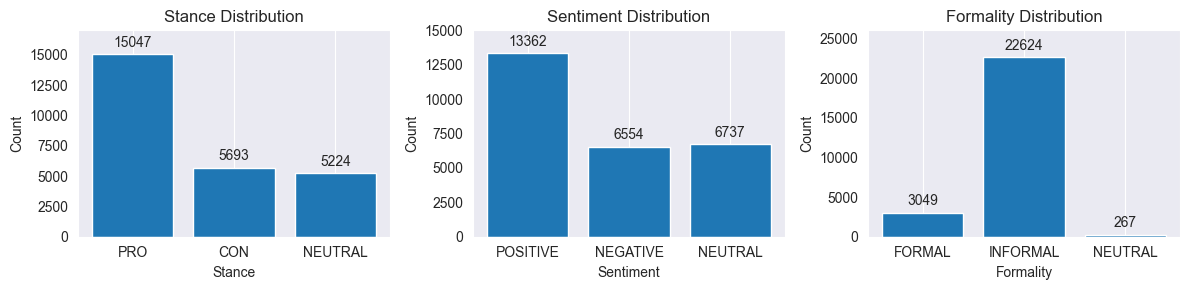

In [174]:
import matplotlib.pyplot as plt

# fig and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# 1) stance
stance_counts = stance_df["stance"].value_counts().sort_index()
ax0 = axes[0]
bars0 = ax0.bar(stance_counts.index, stance_counts.values)
ax0.set_title("Stance Distribution")
ax0.set_xticks([0, 1, 2])
ax0.set_xticklabels(["PRO", "CON", "NEUTRAL"])
ax0.set_xlabel("Stance")
ax0.set_ylabel("Count")
ax0.grid(axis="y")
ax0.set_ylim(0, 17000)
# annotate
for bar in bars0:
    h = bar.get_height()
    ax0.annotate(
        f"{int(h)}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

# 2) sentiment
sentiment_counts = sentiment_df["sentiment"].value_counts().sort_index()
ax1 = axes[1]
bars1 = ax1.bar(sentiment_counts.index, sentiment_counts.values)
ax1.set_title("Sentiment Distribution")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(["POSITIVE", "NEGATIVE", "NEUTRAL"])
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")
ax1.grid(axis="y")
ax1.set_ylim(0, 15000)
# annotate
for bar in bars1:
    h = bar.get_height()
    ax1.annotate(
        f"{int(h)}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

# 3) formality
formality_counts = formality_df["formality"].value_counts().sort_index()
ax2 = axes[2]
bars2 = ax2.bar(formality_counts.index, formality_counts.values)
ax2.set_title("Formality Distribution")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(["FORMAL", "INFORMAL", "NEUTRAL"])
ax2.set_xlabel("Formality")
ax2.set_ylabel("Count")
ax2.grid(axis="y")
ax2.set_ylim(0, 26000)
# annotate
for bar in bars2:
    h = bar.get_height()
    ax2.annotate(
        f"{int(h)}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.savefig("plots/tagged_attribute_dist_caes.pdf", format="pdf", bbox_inches="tight")

In [137]:
stance_df["stance"].map(stance_labels).value_counts().reindex(["PRO", "CON", "NEUTRAL"])

stance
PRO        15047
CON         5693
NEUTRAL     5224
Name: count, dtype: int64

In [138]:
sentiment_df["sentiment"].map(sentiment_labels).value_counts().reindex(["POSITIVE", "NEGATIVE", "NEUTRAL"])

sentiment
POSITIVE    13362
NEGATIVE     6554
NEUTRAL      6737
Name: count, dtype: int64

In [139]:
formality_df["formality"].map(formality_labels).value_counts().reindex(["FORMAL", "INFORMAL", "NEUTRAL"])

formality
FORMAL       3049
INFORMAL    22624
NEUTRAL       267
Name: count, dtype: int64

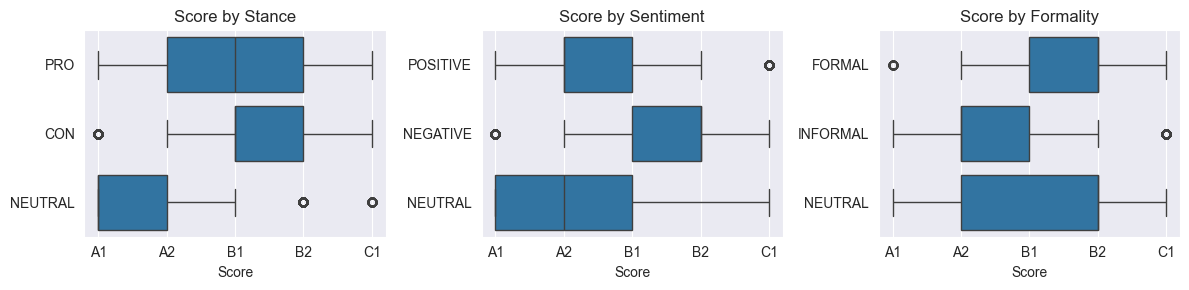

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# order
df_tagged['score'] = pd.Categorical(
    df_tagged['score'],
    categories=['A1', 'A2', 'B1', 'B2', 'C1'],
    ordered=True
)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

# stance
sns.boxplot(
    y='stance',
    x='score',
    data=df_tagged,
    ax=axes[0],
    orient='h',

)
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(['PRO', 'CON', 'NEUTRAL'])
axes[0].set_title("Score by Stance")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("")

# sentiment
sns.boxplot(
    y='sentiment',
    x='score',
    data=df_tagged,
    ax=axes[1],
    orient='h',
)
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['POSITIVE', 'NEGATIVE', 'NEUTRAL'])
axes[1].set_title("Score by Sentiment")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("")

# formality
sns.boxplot(
    y='formality',
    x='score',
    data=df_tagged,
    ax=axes[2],
    orient='h',
)
axes[2].set_yticks([0, 1, 2])
axes[2].set_yticklabels(['FORMAL', 'INFORMAL', 'NEUTRAL'])
axes[2].set_title("Score by Formality")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("plots/caes_tagged_attribute_box_plots.pdf", format="pdf", bbox_inches="tight")

#### Ordered Regression Model to predict scores:

y = predicted score, x = combination of features (attributes of stance, sentiment and formality)

In [141]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# map of cefr scores for conversion
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

# prepare data
df = df_tagged.dropna(subset=["stance", "sentiment", "formality", "score"])
df = df.copy()
df["og_num"] = df["score"].map(CEFR_MAP)
df.loc[:, "stance"] = df["stance"].astype(int)
df.loc[:, "sentiment"] = df["sentiment"].astype(int)
df.loc[:, "formality"] = df["formality"].astype(int)
df.loc[:, "og_num"] = df["og_num"].astype(int)

# fit regression model
model = OrderedModel(
    df["og_num"],
    pd.get_dummies(df[["stance", "sentiment", "formality"]], drop_first=True),
    distr="logit"
)
res = model.fit(method='bfgs')
res.summary()

Optimization terminated successfully.
         Current function value: 1.474430
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 og_num   Log-Likelihood:                -37266.
Model:                   OrderedModel   AIC:                         7.455e+04
Method:            Maximum Likelihood   BIC:                         7.460e+04
Date:                Sun, 27 Jul 2025                                         
Time:                        15:08:14                                         
No. Observations:               25275                                         
Df Residuals:                   25268                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
stance        -0.6909      0.015    -45.388      0.000      -0.721      -0.661
sentiment     -0.0990      0.014     -6.948      0.000      -0.127      -0.071
formality     -1.4573      0.034    -42.997      0.000      -1.524      -1.391
1/2           -3.2386      0.039    -83.217      0.000      -3.315      -3.162
2/3            0.3805      0.011     35.317      0.000       0.359       0.402
3/4            0.1363      0.012     11.381      0.000       0.113       0.160
4/5            0.1973      0.015     13.215      0.000       0.168       0.227
==============================================================================
"""

In [142]:
import itertools
import pandas as pd
from scipy.special import expit

# regression coefficients
beta = {
    'stance':   -0.6909,
    'sentiment': -0.0990,
    'formality':-1.4573
}

# five taus from fitted model
tau = [
    -3.2386,  # tau1 (1/2)
     0.3805,  # tau2 (2/3)
     0.1363,  # tau3 (3/4)
     0.1973,  # tau4 (4/5)
     0.0000   # tau5 (5/6)
]

rows = []
for sentiment, formality, stance in itertools.product([0,1,2], [0,1,2], [0,1,2]):
    # get linear predictor
    eta = (sentiment*beta['sentiment'] + formality*beta['formality'] + stance*beta['stance'])
    # cumulative probs
    cdf = [expit(t - eta) for t in tau]
    cdf = [0.0] + cdf + [1.0]  # pad

    # category probs
    probs = [cdf[j] - cdf[j-1] for j in range(1,7)]

    # expected score
    exp_score = sum(j * p for j,p in enumerate(probs, start=1))

    rows.append({
        'sentiment': ['POSITIVE','NEGATIVE','NEUTRAL'][sentiment],
        'formality': ['FORMAL','INFORMAL','NEUTRAL'][formality],
        'stance':    ['PRO','CON','NEUTRAL'][stance],
        'linear_score_advantage': eta,
        'expected_score':  round(exp_score, 3)
    })

df = pd.DataFrame(rows)
df

,sentiment,formality,stance,linear_score_advantage,expected_score
0,POSITIVE,FORMAL,PRO,-0.0000,3.785
1,POSITIVE,FORMAL,CON,-0.6909,3.112
2,POSITIVE,FORMAL,NEUTRAL,-1.3818,2.563
3,POSITIVE,INFORMAL,PRO,-1.4573,2.511
4,POSITIVE,INFORMAL,CON,-2.1482,2.107
5,POSITIVE,INFORMAL,NEUTRAL,-2.8391,1.787
6,POSITIVE,NEUTRAL,PRO,-2.9146,1.755
7,POSITIVE,NEUTRAL,CON,-3.6055,1.499
8,POSITIVE,NEUTRAL,NEUTRAL,-4.2964,1.303
9,NEGATIVE,FORMAL,PRO,-0.0990,3.684


### Scored Dataset

In [143]:
import os
import pandas as pd

# strings for file loading
base_folder = "counterfactuals_scored/caes"
models = ["gemma3", "qwen3", "deepseek"]
filenames = [
    "formality_formal_to_informal_scored.csv",
    "formality_informal_to_formal_scored.csv",
    "sentiment_negative_to_positive_scored.csv",
    "sentiment_positive_to_negative_scored.csv",
    "stance_con_to_pro_scored.csv",
    "stance_pro_to_con_scored.csv"
]

all_data = []
for model in models:
    for fname in filenames:
        fpath = os.path.join(base_folder, model, fname)
        if os.path.exists(fpath):
            df = pd.read_csv(fpath)
            df['model'] = model
            df['direction'] = fname.replace("_scored.csv", "")
            all_data.append(df)
        else:
            print(f"Missing file: {fpath}")

# combine all into a single dataframe
df_all = pd.concat(all_data, ignore_index=True)

# separate essay_code into two attributes
df_all['version'] = df_all['essay_code'].apply(lambda x: 'OR' if x.endswith('-O') else 'CF')
df_all['essay_id'] = df_all['essay_code'].str.extract(r'(\d+)-')[0].astype(int)

# sort and show
df_all.sort_values(by=['model', 'direction', 'essay_id', 'version'], inplace=True)
df_all = df_all.dropna(subset=["score_llm"]).reset_index(drop=True)
df_all

,essay_code,full_text,attribute,label,score_og,score_llm,model,direction,version,essay_id
0,429-CFO,"hola, soy kseniya, estudio en la universidad d...",formality,1,A2,A1,deepseek,formality_formal_to_informal,CF,429
1,429-O,"soy kseniya , estudiante de la univeridad_de_m...",formality,0,A2,A1,deepseek,formality_formal_to_informal,OR,429
2,534-CFO,escribo pa’ quejarme de mi equipaje. es que en...,formality,1,B1,A1,deepseek,formality_formal_to_informal,CF,534
3,534-O,escribo para reclamar mi equipaje . es que en ...,formality,0,B1,A1,deepseek,formality_formal_to_informal,OR,534
4,687-CFO,"durante esa semana, me siento súper mal por có...",formality,1,B1,A1,deepseek,formality_formal_to_informal,CF,687
...,...,...,...,...,...,...,...,...,...,...
3585,24962-O,"hace una semana , fui a participar en una acti...",stance,0,B1,B1,qwen3,stance_pro_to_con,OR,24962
3586,26155-CST,¡ hola sara ! ¿ que tal sarita ? ¿ y como esta...,stance,1,B1,B1,qwen3,stance_pro_to_con,CF,26155
3587,26155-O,¡ hola sara ! ¿ que tal sarita ? ¿ y como esta...,stance,0,B1,B1,qwen3,stance_pro_to_con,OR,26155
3588,26269-CST,! hola anastasia ! ? como te vas ? ? como la v...,stance,1,B1,B1,qwen3,stance_pro_to_con,CF,26269


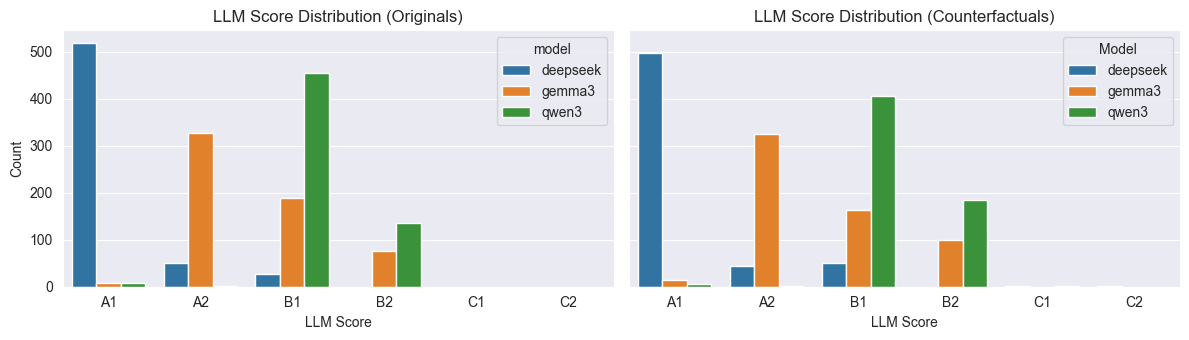

In [144]:
# get cfs and originals
df_orig = df_all[df_all["version"].str.contains("OR")]
df_cf = df_all[df_all["version"].str.contains("CF")]

# handle order and colors
score_order = sorted(df_all["score_llm"].dropna().unique())
model_list = sorted(df_all["model"].dropna().unique())  # Ensures consistent model ordering
model_palette = sns.color_palette("tab10", len(model_list))
model_colors = dict(zip(model_list, model_palette))

# subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=True)

# original plot
sns.countplot(
    data=df_orig, x="score_llm", hue="model",
    order=score_order, hue_order=model_list,
    ax=axes[0], palette=model_colors
)
axes[0].set_title("LLM Score Distribution (Originals)")
axes[0].set_xlabel("LLM Score")
axes[0].set_ylabel("Count")

# cf plot
sns.countplot(
    data=df_cf, x="score_llm", hue="model",
    order=score_order, hue_order=model_list,
    ax=axes[1], palette=model_colors
)
axes[1].set_title("LLM Score Distribution (Counterfactuals)")
axes[1].set_xlabel("LLM Score")
axes[1].set_ylabel("Count")
axes[1].legend(title="Model")

plt.tight_layout()
plt.savefig("plots/caes_llm_score_dist.pdf", format="pdf", bbox_inches="tight")

In [145]:
import pandas as pd

# order. assume cefr goes from 1 to 6
cefr_order = ['A1','A2','B1','B2','C1','C2']
cat_type   = pd.CategoricalDtype(categories=cefr_order, ordered=True)
df_all['score_cat'] = df_all['score_llm'].astype(cat_type)
df_all['score_num'] = df_all['score_cat'].cat.codes + 1

# calc mean diff
mean_diff_df = (
    df_all[df_all["version"].isin(["OR", "CF"])]
    .groupby(["model", "direction", "version"])["score_num"]  # <- use score_num
    .mean()
    .unstack("version")
    .reset_index()
)

mean_diff_df["diff"] = mean_diff_df["CF"] - mean_diff_df["OR"]
mean_diff_df["change"] = mean_diff_df["diff"].apply(
    lambda x: "increase" if x > 0 else "decrease" if x < 0 else "no change"
)

mean_diff_df

version,model,direction,CF,OR,diff,change
0,deepseek,formality_formal_to_informal,1.230000,1.130000,0.100000,increase
1,deepseek,formality_informal_to_formal,1.438776,1.100000,0.338776,increase
2,deepseek,sentiment_negative_to_positive,1.170000,1.120000,0.050000,increase
3,deepseek,sentiment_positive_to_negative,1.173469,1.252525,-0.079056,decrease
4,deepseek,stance_con_to_pro,1.323232,1.171717,0.151515,increase
5,deepseek,stance_pro_to_con,1.272727,1.265306,0.007421,increase
6,gemma3,formality_formal_to_informal,2.280000,2.610000,-0.330000,decrease
7,gemma3,formality_informal_to_formal,2.720000,2.400000,0.320000,increase
8,gemma3,sentiment_negative_to_positive,2.520000,2.500000,0.020000,increase
9,gemma3,sentiment_positive_to_negative,2.610000,2.650000,-0.040000,decrease


In [146]:
# average difference between ogs and counterfactuals

avg_diff = (
    mean_diff_df
    .groupby("direction")["diff"]
    .mean()
    .reset_index()
    .rename(columns={"diff":"avg_diff_all_models"})
)

change_counts = (
    mean_diff_df
    .groupby(["direction","change"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

direction_summary = avg_diff.merge(change_counts, on="direction")

direction_summary

,direction,avg_diff_all_models,decrease,increase
0,formality_formal_to_informal,-0.123333,2,1
1,formality_informal_to_formal,0.356259,0,3
2,sentiment_negative_to_positive,0.070000,0,3
3,sentiment_positive_to_negative,-0.069685,3,0
4,stance_con_to_pro,0.147172,0,3
5,stance_pro_to_con,0.035807,0,3


In [147]:
# including avg cf score and avg originals score on columns

avg_scores = (
    mean_diff_df
    .groupby("direction")[["CF","OR"]]
    .mean()
    .reset_index()
    .rename(columns={
        "CF": "avg_cf_score",
        "OR": "avg_or_score"
    })
)

direction_summary = (
    avg_diff
    .merge(change_counts, on="direction")
    .merge(avg_scores,   on="direction")
)

direction_summary

,direction,avg_diff_all_models,decrease,increase,avg_cf_score,avg_or_score
0,formality_formal_to_informal,-0.123333,2,1,2.220000,2.343333
1,formality_informal_to_formal,0.356259,0,3,2.542925,2.186667
2,sentiment_negative_to_positive,0.070000,0,3,2.330000,2.260000
3,sentiment_positive_to_negative,-0.069685,3,0,2.321156,2.390842
4,stance_con_to_pro,0.147172,0,3,2.431077,2.283906
5,stance_pro_to_con,0.035807,0,3,2.434242,2.398435


### Metrics (Bias and performance)

In [148]:
import glob
import os
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# map from CEFR level to numbers between 1 and 6
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

def compute_qwk(df, mode="both"):
    # drop any nulls
    df = df.dropna(subset=["score_og", "score_llm"]).copy()

    # map CEFR strings -> ints
    df["og_num"]  = df["score_og"].map(CEFR_MAP)
    df["llm_num"] = df["score_llm"].map(CEFR_MAP)

    # select originals or CFs or both
    if mode == "OR":
        sel = df[df["essay_code"].str.endswith("-O")]
    elif mode == "CF":
        sel = df[df["essay_code"].str.contains("-C")]
    else:
        sel = df
    return cohen_kappa_score(sel["og_num"], sel["llm_num"], weights="quadratic")

# load all CAES counterfactual CSVs
BASE = "counterfactuals_scored/caes"
models = {}
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    paths = glob.glob(os.path.join(model_dir, "*_scored.csv"))
    if not paths:
        print(f"no files for {model_name}, skipping")
        continue

    df_all = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
    models[model_name] = df_all

# compute & print CEFR‐mapped QWKs
for name, df in models.items():
    q_or   = compute_qwk(df, "OR")
    q_cf   = compute_qwk(df, "CF")
    q_both = compute_qwk(df, "both")
    print(f"\n=== QWK for {name} ===")
    print(f" originals: {q_or:.4f}")
    print(f" counterfactuals: {q_cf:.4f}")
    print(f" diff: {q_or - q_cf:.4f}")
    print(f" combined: {q_both:.4f}")


=== QWK for gemma3 ===
 originals: 0.5768
 counterfactuals: 0.6002
 diff: -0.0234
 combined: 0.5887

=== QWK for qwen3 ===
 originals: 0.3027
 counterfactuals: 0.3280
 diff: -0.0253
 combined: 0.3158

=== QWK for deepseek ===
 originals: 0.1006
 counterfactuals: 0.1226
 diff: -0.0221
 combined: 0.1115


In [149]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# calculates osd csd via regression models (to get r2 coefficients)
# score_og : human score H
# score_llm: AES score S
# label : 0 or 1 (the flip indicator)
# osd_r2 : R2 coeff from regressing |S−H| ~ label
# csd_delta_r2 : (R2 from |S−H| ~ H + label) minus (R2 from |S−H| ~ H)
def compute_osd_csd_regression(df):
    # 1) drop nulls & cast
    df = df.dropna(subset=['score_og','score_llm','label']).copy()
    df['label'] = df['label'].astype(int)

    # map CEFR strings -> ints
    df["og_num"] = df["score_og"].map(CEFR_MAP)
    df["llm_num"] = df["score_llm"].map(CEFR_MAP)

    # 2) compute absolute error
    df['abs_error'] = np.abs(df['llm_num'] - df['og_num'])

    X_label = df[['label']].values
    X_H = df[['og_num']].values
    X_both = df[['og_num','label']].values
    y = df['abs_error'].values

    # 3) Fit OSD model: abs_error ~ label
    lm_osd = LinearRegression().fit(X_label, y)
    y_pred_osd = lm_osd.predict(X_label)
    osd_r2 = r2_score(y, y_pred_osd)

    # 4) Fit two models for CSD:
    #    (a) abs_error ~ H
    lm_csd_1 = LinearRegression().fit(X_H, y)
    y1 = lm_csd_1.predict(X_H)
    r2_1 = r2_score(y, y1)

    #    (b) abs_error ~ H + label
    lm_csd_2 = LinearRegression().fit(X_both, y)
    y2 = lm_csd_2.predict(X_both)
    r2_2 = r2_score(y, y2)

    csd_delta_r2 = r2_2 - r2_1

    return osd_r2, csd_delta_r2

In [150]:
import glob, os

BASE = "counterfactuals_scored/caes"
results = []

# loop to get a summary of osd r2 and csd r2 in one table for each flip for each model
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    for csv_path in glob.glob(os.path.join(model_dir, "*.csv")):
        df = pd.read_csv(csv_path)
        osd_r2, csd_delta_r2 = compute_osd_csd_regression(df)

        results.append({
            "model": model_name,
            "flip_file": os.path.basename(csv_path),
            "OSD_R2": osd_r2,
            "CSD_delta_R2": csd_delta_r2
        })

df_results = pd.DataFrame(results)
df_results

,model,flip_file,OSD_R2,CSD_delta_R2
0,gemma3,sentiment_positive_to_negative_scored.csv,0.000000e+00,0.000000
1,gemma3,stance_con_to_pro_scored.csv,9.317361e-03,0.009317
2,gemma3,formality_formal_to_informal_scored.csv,2.225026e-02,0.022250
3,gemma3,sentiment_negative_to_positive_scored.csv,6.289308e-03,0.006289
4,gemma3,stance_pro_to_con_scored.csv,1.682243e-02,0.016822
5,gemma3,formality_informal_to_formal_scored.csv,1.382619e-02,0.013826
6,qwen3,sentiment_positive_to_negative_scored.csv,4.171495e-04,0.000417
7,qwen3,stance_con_to_pro_scored.csv,2.540754e-02,0.025408
8,qwen3,formality_formal_to_informal_scored.csv,5.480203e-04,0.000548
9,qwen3,sentiment_negative_to_positive_scored.csv,1.110223e-16,0.000000


In [151]:
# average osd and csd r2s per flip
avg_by_flip = (
    df_results
    .groupby('flip_file')[['OSD_R2', 'CSD_delta_R2']]
    .mean()
    .reset_index()
    .rename(columns={'OSD_R2': 'AVG_OSD_R2', 'CSD_delta_R2': 'AVG_CSD_delta_R2'})
)

avg_by_flip = (
    avg_by_flip
    .sort_values('AVG_CSD_delta_R2', ascending=False)
    .reset_index(drop=True)
    .round(4)
)

avg_by_flip

,flip_file,AVG_OSD_R2,AVG_CSD_delta_R2
0,stance_con_to_pro_scored.csv,0.0119,0.0123
1,formality_formal_to_informal_scored.csv,0.0079,0.0079
2,formality_informal_to_formal_scored.csv,0.0064,0.0063
3,stance_pro_to_con_scored.csv,0.0058,0.0060
4,sentiment_negative_to_positive_scored.csv,0.0021,0.0021
5,sentiment_positive_to_negative_scored.csv,0.0003,0.0004


In [152]:
# average osd and csd r2s per model
avg_by_model = (
    df_results
    .groupby('model')[['OSD_R2', 'CSD_delta_R2']]
    .mean()
    .reset_index()
    .rename(columns={'OSD_R2': 'AVG_OSD_R2', 'CSD_delta_R2': 'AVG_CSD_delta_R2'})
)

avg_by_model = (
    avg_by_model
    .sort_values('AVG_CSD_delta_R2', ascending=False)
    .reset_index(drop=True)
    .round(4)
)

avg_by_model

,model,AVG_OSD_R2,AVG_CSD_delta_R2
0,gemma3,0.0114,0.0114
1,qwen3,0.0050,0.0050
2,deepseek,0.0009,0.0011


In [153]:
import glob
import os
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# computes qwk, accuracy, and F1 from df depending on mode (original, cf, or both)
def compute_metrics(df, mode):
    # drop any rows missing either label
    df = df.dropna(subset=["score_og", "score_llm"])
    # select subset
    if mode == "OR":
        sel = df[df["essay_code"].str.endswith("-O")]
    elif mode == "CF":
        sel = df[df["essay_code"].str.contains("-C")]
    else:
        sel = df

    y_true = sel["score_og"]
    y_pred = sel["score_llm"]

    return {
        "qwk":   cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        "acc":   accuracy_score(y_true, y_pred),
        "f1":    f1_score(y_true, y_pred, average="weighted")
    }


# load data in dfs
BASE = "counterfactuals_scored/caes"

models = {}
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    paths = glob.glob(os.path.join(model_dir, "*_scored.csv"))
    if not paths:
        print(f"no files for {model_name}, skipping")
        continue

    dfs = [pd.read_csv(p) for p in paths]
    models[model_name] = pd.concat(dfs, ignore_index=True)


# get per‐model QWK, accuracy, F1
for name, df in models.items():
    m_or  = compute_metrics(df, "OR")
    m_cf  = compute_metrics(df, "CF")
    m_both = compute_metrics(df, "both")

    print(f"\n=== Metrics for {name} ===")
    print(f" ORIGINALS:")
    print(f"   QWK:  {m_or['qwk']:.3f}")
    print(f"   ACC:  {m_or['acc']:.3f}")
    print(f"   F1:   {m_or['f1']:.3f}")
    print(f" COUNTERFACTUALS:")
    print(f"   QWK:  {m_cf['qwk']:.3f}")
    print(f"   ACC:  {m_cf['acc']:.3f}")
    print(f"   F1:   {m_cf['f1']:.3f}")
    print(f" DIFF (orig − cf):")
    print(f"   ΔQWK: {m_or['qwk'] - m_cf['qwk']:.3f}")
    print(f"   ΔACC: {m_or['acc'] - m_cf['acc']:.3f}")
    print(f"   ΔF1:  {m_or['f1']  - m_cf['f1']:.3f}")
    print(f" COMBINED:")
    print(f"   QWK:  {m_both['qwk']:.3f}")
    print(f"   ACC:  {m_both['acc']:.3f}")
    print(f"   F1:   {m_both['f1']:.3f}")


=== Metrics for gemma3 ===
 ORIGINALS:
   QWK:  0.577
   ACC:  0.418
   F1:   0.352
 COUNTERFACTUALS:
   QWK:  0.600
   ACC:  0.410
   F1:   0.349
 DIFF (orig − cf):
   ΔQWK: -0.023
   ΔACC: 0.008
   ΔF1:  0.003
 COMBINED:
   QWK:  0.589
   ACC:  0.414
   F1:   0.351

=== Metrics for qwen3 ===
 ORIGINALS:
   QWK:  0.303
   ACC:  0.347
   F1:   0.229
 COUNTERFACTUALS:
   QWK:  0.328
   ACC:  0.300
   F1:   0.186
 DIFF (orig − cf):
   ΔQWK: -0.025
   ΔACC: 0.047
   ΔF1:  0.044
 COMBINED:
   QWK:  0.316
   ACC:  0.323
   F1:   0.207

=== Metrics for deepseek ===
 ORIGINALS:
   QWK:  0.101
   ACC:  0.227
   F1:   0.113
 COUNTERFACTUALS:
   QWK:  0.123
   ACC:  0.227
   F1:   0.126
 DIFF (orig − cf):
   ΔQWK: -0.022
   ΔACC: -0.001
   ΔF1:  -0.013
 COMBINED:
   QWK:  0.111
   ACC:  0.227
   F1:   0.120


### JS distance

In [154]:
import glob
import os
import pandas as pd
from scipy.spatial.distance import jensenshannon

# map from CEFR level to numbers between 1 and 6
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

def compute_js(df, score_col='score_llm', code_col='essay_code'):
    df = df.dropna(subset=[score_col]).copy()
    # create version column depending on whether it has -O or -CFO (else)
    df['version'] = np.where(
        df[code_col].str.endswith('-O'),
        'OR',
        'CF'
    )

    # count vectors
    bins = sorted(df[score_col].unique())
    og_counts = df[df['version']=='OR'][score_col].value_counts().reindex(bins, fill_value=0)
    cf_counts = df[df['version']=='CF'][score_col].value_counts().reindex(bins, fill_value=0)

    P = og_counts.values / og_counts.sum()
    Q = cf_counts.values / cf_counts.sum()

    dist = jensenshannon(P, Q, base=2)
    div = dist**2

    return dist, div

BASE = "counterfactuals_scored/caes"
models = {}
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    paths = glob.glob(os.path.join(model_dir, "*_scored.csv"))
    if not paths:
        print(f"no files for {model_name}, skipping")
        continue

    dfs = [pd.read_csv(p) for p in paths]
    df_all = pd.concat(dfs, ignore_index=True)
    models[model_name] = df_all

for name, df in models.items():
    js_dist, js_div = compute_js(df, score_col='score_llm')

    print(f"\n=== {name} ===")
    print(f"JS distance (OR vs CF):   {js_dist:.4f}")
    print(f"JS divergence (OR vs CF):  {js_div:.4f}")


=== gemma3 ===
JS distance (OR vs CF):   0.0617
JS divergence (OR vs CF):  0.0038

=== qwen3 ===
JS distance (OR vs CF):   0.0900
JS divergence (OR vs CF):  0.0081

=== deepseek ===
JS distance (OR vs CF):   0.0907
JS divergence (OR vs CF):  0.0082


### QWK and JS distance per flip per model

In [155]:
import glob, os
import numpy as np
from sklearn.metrics import cohen_kappa_score
from scipy.spatial import distance

BASE = "counterfactuals_scored/caes"

def extract_direction_from_path(path):
    fname = os.path.basename(path)
    return fname.replace("_scored.csv", "")

def load_model_dfs(base):
    models = {}
    for model in os.listdir(base):
        d = os.path.join(base, model)
        if not os.path.isdir(d): continue
        parts = []
        for csvf in glob.glob(os.path.join(d, "*_scored.csv")):
            df = pd.read_csv(csvf)
            df["direction"] = extract_direction_from_path(csvf)
            parts.append(df)
        if parts:
            models[model] = pd.concat(parts, ignore_index=True)
    return models

def qwk_for_flip(df, flip):
    sub = df[df["direction"] == flip].dropna(subset=["score_og_num","score_llm_num"])
    orig = sub[sub["essay_code"].str.endswith("-O")]
    cf   = sub[sub["essay_code"].str.contains("-C")]
    return (
        cohen_kappa_score(orig["score_og_num"], orig["score_llm_num"], weights="quadratic"),
        cohen_kappa_score(cf["score_og_num"],   cf["score_llm_num"],   weights="quadratic"),
        cohen_kappa_score(sub["score_og_num"],   sub["score_llm_num"],   weights="quadratic"),
    )

def js_for_flip(df, flip):
    sub = df[df["direction"] == flip].dropna(subset=["score_llm_num"])
    support = sorted(sub["score_llm_num"].astype(int).unique())
    def hist(srs):
        cnt = np.bincount(srs.astype(int), minlength=max(support)+1)[support]
        return cnt / cnt.sum()
    p_or = hist(sub[sub["essay_code"].str.endswith("-O")]["score_llm_num"])
    p_cf = hist(sub[sub["essay_code"].str.contains("-C")]["score_llm_num"])
    jsd  = distance.jensenshannon(p_or, p_cf)
    return jsd, jsd**2

# load everything
models = load_model_dfs(BASE)

# map
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

# map both score types
for model_name, df in models.items():
    df["score_og_num"]  = df["score_og"].map(CEFR_MAP)
    df["score_llm_num"] = df["score_llm"].map(CEFR_MAP)

    print(f"\n=== Model: {model_name} ===")
    for flip in sorted(df["direction"].unique()):
        q_or, q_cf, q_both = qwk_for_flip(df, flip)
        jsd, js2   = js_for_flip(df, flip)
        print(f"{flip:30s}  QWK(OR)={q_or:.3f}  QWK(CF)={q_cf:.3f}  QWK(both)={q_both:.3f}  Δ={q_or-q_cf:.3f}  "
              f"JSdist={jsd:.3f}  JSdiv={js2:.4f}")


=== Model: gemma3 ===
formality_formal_to_informal    QWK(OR)=0.543  QWK(CF)=0.308  QWK(both)=0.427  Δ=0.234  JSdist=0.185  JSdiv=0.0343
formality_informal_to_formal    QWK(OR)=0.551  QWK(CF)=0.738  QWK(both)=0.650  Δ=-0.187  JSdist=0.195  JSdiv=0.0379
sentiment_negative_to_positive  QWK(OR)=0.567  QWK(CF)=0.677  QWK(both)=0.625  Δ=-0.110  JSdist=0.137  JSdiv=0.0187
sentiment_positive_to_negative  QWK(OR)=0.613  QWK(CF)=0.648  QWK(both)=0.630  Δ=-0.035  JSdist=0.053  JSdiv=0.0028
stance_con_to_pro               QWK(OR)=0.562  QWK(CF)=0.472  QWK(both)=0.517  Δ=0.090  JSdist=0.046  JSdiv=0.0021
stance_pro_to_con               QWK(OR)=0.622  QWK(CF)=0.733  QWK(both)=0.679  Δ=-0.111  JSdist=0.046  JSdiv=0.0021

=== Model: qwen3 ===
formality_formal_to_informal    QWK(OR)=0.182  QWK(CF)=0.185  QWK(both)=0.183  Δ=-0.003  JSdist=0.122  JSdiv=0.0148
formality_informal_to_formal    QWK(OR)=0.267  QWK(CF)=0.362  QWK(both)=0.321  Δ=-0.095  JSdist=0.301  JSdiv=0.0905
sentiment_negative_to_positiv

#### Diagram to capture bias difference (og and cfs) per flip per model:

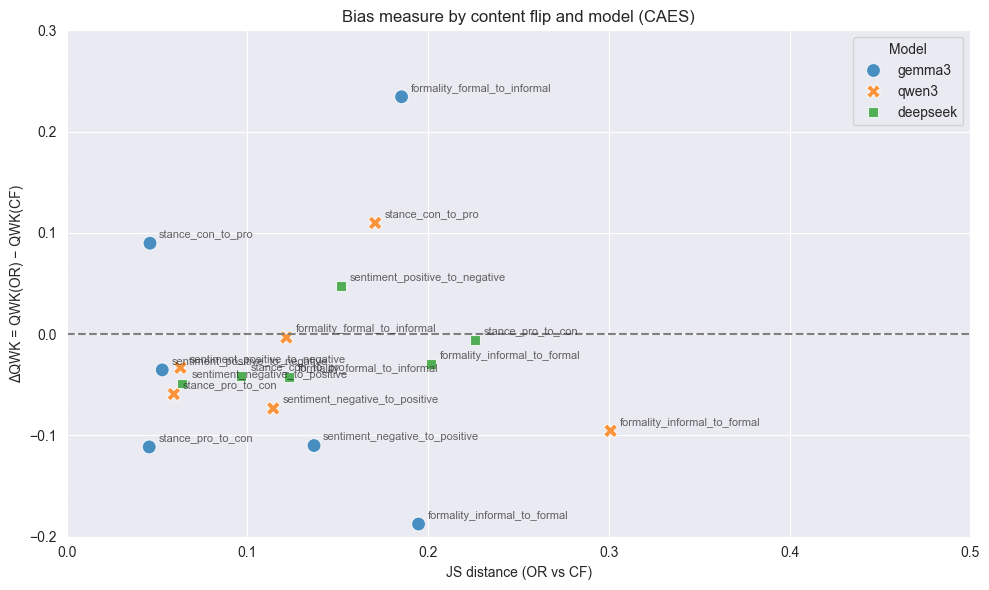

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# flat df with one row per (model, flip)
records = []
for model_name, df in models.items():
    for flip in sorted(df["direction"].unique()):
        q_or, q_cf, q_both = qwk_for_flip(df, flip)
        jsd, js2 = js_for_flip(df, flip)
        records.append({
            "model": model_name,
            "flip":  flip,
            "ΔQWK":  q_or - q_cf,
            "JSdist": jsd
        })
plot_df = pd.DataFrame(records)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=plot_df,
    x="JSdist", y="ΔQWK",
    hue="model",
    style="model",
    s=100,
    alpha=0.8
)

# annotate each point with its flip name
for _, row in plot_df.iterrows():
    plt.text(
        row["JSdist"] + 0.005,
        row["ΔQWK"] + 0.005,
        row["flip"],
        fontsize=8,
        alpha=0.7
    )

plt.xlim(0.0, 0.5)
plt.ylim(-0.2, 0.3)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("JS distance (OR vs CF)")
plt.ylabel("ΔQWK = QWK(OR) − QWK(CF)")
plt.title("Bias measure by content flip and model (CAES)")
plt.legend(title="Model")
plt.tight_layout()

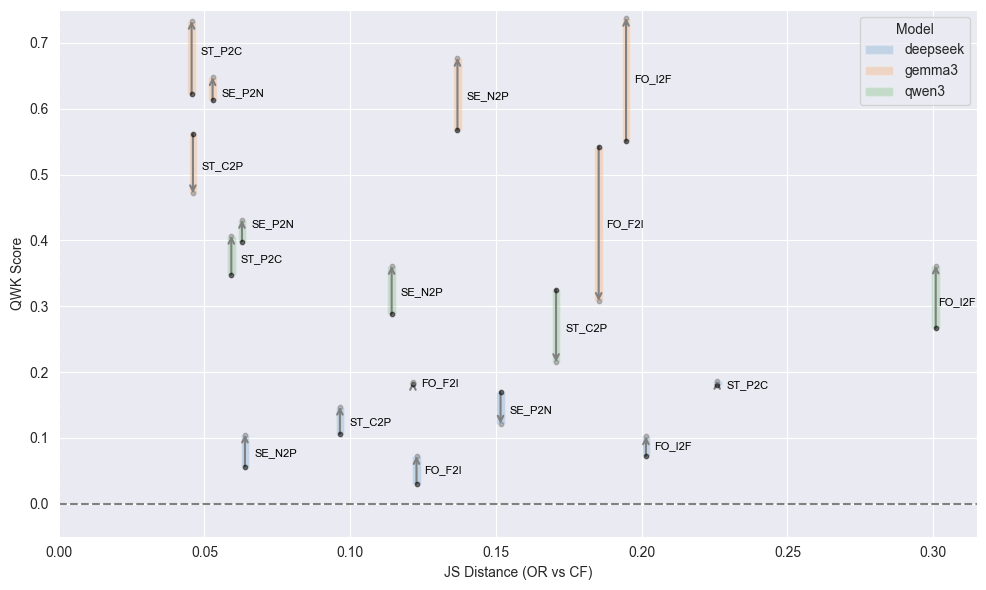

In [160]:
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
import matplotlib.collections as mcoll
import matplotlib.transforms as mtrans

# translation map
label_map = {
    'stance_pro_to_con':             'ST_P2C',
    'stance_con_to_pro':             'ST_C2P',
    'sentiment_positive_to_negative':'SE_P2N',
    'sentiment_negative_to_positive':'SE_N2P',
    'formality_formal_to_informal':  'FO_F2I',
    'formality_informal_to_formal':  'FO_I2F'
}

# 1) Build plot_df with both q_or & q_cf
records = []
for model_name, df_model in models.items():
    for flip in sorted(df_model["direction"].unique()):
        q_or, q_cf, _ = qwk_for_flip(df_model, flip)
        jsd, _        = js_for_flip(df_model, flip)
        records.append({
            "model":  model_name,
            "flip":   flip,
            "JSdist": jsd,
            "q_or":   q_or,
            "q_cf":   q_cf,
        })
plot_df = pd.DataFrame(records)

# 1b) add the short‐label column
plot_df['flip_label'] = plot_df['flip'].map(label_map).fillna(plot_df['flip'])

# 2) set up the figure & axes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.003

# 3) draw floating bars, arrows, and endpoint dots
for model_name, group in plot_df.groupby("model"):
    group = group.sort_values("JSdist")
    bars = ax.bar(
        x=group["JSdist"],
        height=group["q_cf"] - group["q_or"],
        bottom=group["q_or"],
        width=bar_width,
        alpha=0.2,
        label=model_name
    )

    for bar, (_, row) in zip(bars, group.iterrows()):
        x, y0, y1 = row["JSdist"], row["q_or"], row["q_cf"]
        if y1 != y0:
            ax.annotate(
                "",
                xy=(x, y1),
                xytext=(x, y0),
                arrowprops=dict(
                    arrowstyle="->",
                    color="gray",
                    lw=1.5,
                    shrinkA=0, shrinkB=0
                ),
                annotation_clip=False
            )
        else:
            ax.plot(x, y0, marker="o", color="black", markersize=5, zorder=4)

    # endpoint dots
    ax.scatter(group["JSdist"], group["q_or"], color="black", s=10, zorder=5, alpha=0.5)
    ax.scatter(group["JSdist"], group["q_cf"], color="gray", s=10, zorder=5, alpha=0.5)

# collect bars and dots to avoid
bar_artists = [patch for cont in ax.containers for patch in cont.patches]
dot_artists = [col for col in ax.collections
               if isinstance(col, mcoll.PathCollection)]

offset = mtrans.ScaledTranslation(4/72, 0, fig.dpi_scale_trans)

texts = []
for _, row in plot_df.iterrows():
    y_mid = 0.5 * (row['q_or'] + row['q_cf'])
    txt = ax.text(row['JSdist'], y_mid, row['flip_label'],
                  transform=ax.transData + offset,
                  va='center', fontsize=8, color="black")
    texts.append(txt)

adjust_text(
    texts,
    ax=ax,
    add_objects=bar_artists,          # repel rectangles (bars)
    add_points=dot_artists,           # repel scatter points
    expand_objects=(1.2, 1.2),        # 20 % padding around bars
    expand_points=(1.4, 1.4),         # 40 % padding around dots
    force_objects=(0.5, 0.5),         # push off bars a bit
    force_points=(0.8, 0.8),          # push harder off dots
    only_move={'text': 'x'},          # slide horizontally only
    lim=400                           # more optimisation passes
)

# 5) save
ax.axhline(0, color="gray", linestyle="--")
ax.axvline(0, color="gray", linestyle="--")
ax.set_xlim(0.0, 0.315)
ax.set_ylim(-0.05, 0.75)
ax.set_xlabel("JS Distance (OR vs CF)")
ax.set_ylabel("QWK Score")
#ax.set_title("Change in QWK vs JS Distance by Flip & Model")
ax.legend(title="Model")
plt.tight_layout()
fig.savefig("plots/qwk_or_cf_caes.pdf",
            format="pdf",
            bbox_inches="tight")